# ++++++++++++++++++++++++++++++
# Prudential Life Insurance Assessment
# ++++++++++++++++++++++++++++++

## Part 1: Introduction & Data Exploration
## ----------------------------------------------

Author: <a href='mailto:rory_creedon@swissre.com'>Rory Creedon</a><br/>
Date: August 31 2017 <br/>
Purpose: To introduce the <a href='https://www.kaggle.com/c/prudential-life-insurance-assessment'> prudential life insurance assessment</a> data and task and to take a first look at the data.

---

## Introduction to the Challenge

This challenge comes from <a href="https://www.kaggle.com/c/prudential-life-insurance-assessment">Kaggle</a>. The introduction to the original challenge is as follows:

>In a one-click shopping world with on-demand everything, the life insurance application process is antiquated. Customers provide extensive information to identify risk classification and eligibility, including scheduling medical exams, a process that takes an average of 30 days.

>The result? People are turned off. That’s why only 40% of U.S. households own individual life insurance. Prudential wants to make it quicker and less labor intensive for new and existing customers to get a quote while maintaining privacy boundaries.

>By developing a predictive model that accurately classifies risk using a more automated approach, you can greatly impact public perception of the industry.

The specific instructions are:

>In this dataset, you are provided over a hundred variables describing attributes of life insurance applicants. The task is to predict the "Response" variable for each Id in the test set. "Response" is an ordinal measure of risk that has 8 levels.

The data provided are as follows:

<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Variable</th><th>Description</th></tr></thead><tbody>
 <tr><td>Id</td><td>A unique identifier associated with an application.</td></tr>
 <tr><td>Product_Info_1-7</td><td>A set of normalized variables relating to the product applied for</td></tr>
 <tr><td>Ins_Age</td><td>Normalized age of applicant</td></tr>
 <tr><td>Ht</td><td>Normalized height of applicant</td></tr>
 <tr><td>Wt</td><td>Normalized weight of applicant</td></tr>
 <tr><td>BMI</td><td>Normalized BMI of applicant</td></tr>
 <tr><td>Employment_Info_1-6</td><td>A set of normalized variables relating to the employment history of the applicant.</td></tr>
 <tr><td>InsuredInfo_1-6</td><td>A set of normalized variables providing information about the applicant.</td></tr>
 <tr><td>Insurance_History_1-9</td><td>A set of normalized variables relating to the insurance history of the applicant.</td></tr>
 <tr><td>Family_Hist_1-5</td><td>A set of normalized variables relating to the family history of the applicant.</td></tr>
 <tr><td>Medical_History_1-41</td><td>A set of normalized variables relating to the medical history of the applicant.</td></tr>
 <tr><td>Medical_Keyword_1-48</td><td>A set of dummy variables relating to the presence of/absence of a medical keyword being associated with the application.</td></tr>
 <tr><td>Response</td><td>This is the target variable, an ordinal variable relating to the final decision associated with an application</td></tr>
</tbody></table>

## Research Problem

The problem that I would like to solve is to use a gradient boosting algorithm, specifically the <a href="http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html">H20</a> GBM algorithm to predict the response variable. 

Two datasets are provided by Kaggle, a train set with c.60,000 observations and a test set which is smaller. However, the test set does not contain response data, so I will split the train set into new test and train sets. 

The main model evaluation measure will be the mean per class error.

---

## Exploring the Response and Feature Data

In [1]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('train.csv')

In [3]:
#number of observations
len(df)

59381

In [4]:
#number of columns
len(df.columns)

128

In [5]:
df.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
0,2,1,D3,10,0.076923,2,1,1,0.641791,0.581818,...,0,0,0,0,0,0,0,0,0,8
1,5,1,A1,26,0.076923,2,3,1,0.059701,0.600000,...,0,0,0,0,0,0,0,0,0,4
2,6,1,E1,26,0.076923,2,3,1,0.029851,0.745455,...,0,0,0,0,0,0,0,0,0,8
3,7,1,D4,10,0.487179,2,3,1,0.164179,0.672727,...,0,0,0,0,0,0,0,0,0,8
4,8,1,D2,26,0.230769,2,3,1,0.417910,0.654545,...,0,0,0,0,0,0,0,0,0,8


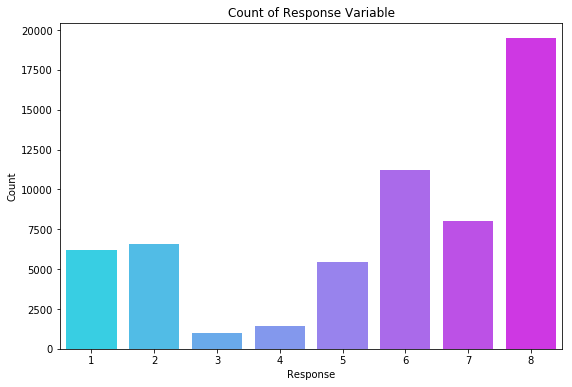

In [6]:
#The response data
sns.countplot(df['Response'], palette="cool")
plt.ylabel("Count")
plt.title("Count of Response Variable")
plt.gcf().set_size_inches(9, 6)

There is a lot of imbalance in the response data, this may need to be considered when creating the final model. It is curious that the distribution of the response variable is like this. In general life insurers want to have the majority of their portfolio in the 'standard' risk class. They will then tolerate a number of preferred risk classes and a number of sub-standard risk classes. Therefore we would normally expect the distribution of risk classes to be more bell shaped. Possibly these data are not drawn from a single portfolio, or the data have been re-scaled.

In [7]:
df.filter(regex='Product').head()

,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7
0,1,D3,10,0.076923,2,1,1
1,1,A1,26,0.076923,2,3,1
2,1,E1,26,0.076923,2,3,1
3,1,D4,10,0.487179,2,3,1
4,1,D2,26,0.230769,2,3,1


There is a lot of information about the product. It seems possible that the product_Info2 is the main type of product, and the remainder are options, such as face amount, riders and other bolt ons that are typical in the insurance industry. 

In [8]:
product = df['Product_Info_2'].value_counts().sort_index()

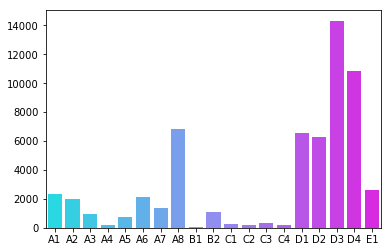

In [9]:
sns.barplot(x=product.index, y = product.values, palette='cool')

The majority of product is in the D/E category. 

It could be interesting to see if the response variable is more "normally" distributed within any of the product types. 

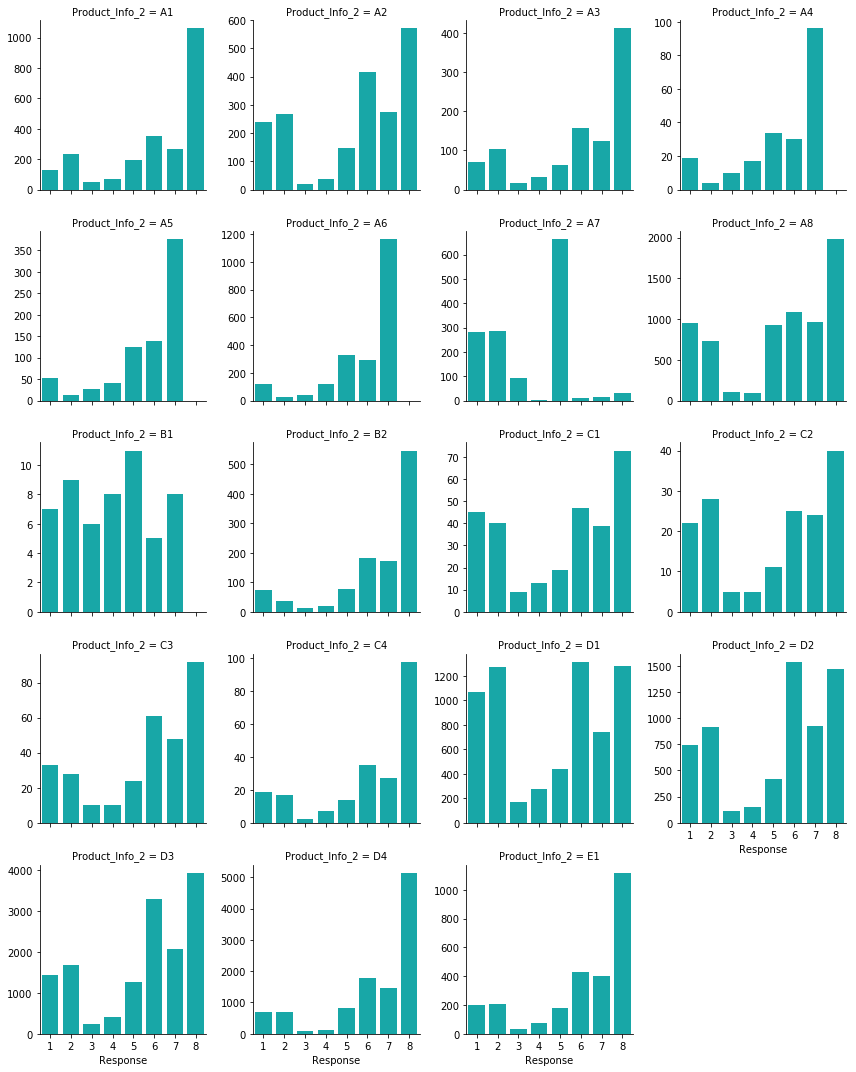

In [10]:
grid = sns.FacetGrid(df, col="Product_Info_2", col_wrap=4, sharey=False, 
                     sharex = True, col_order=product.index)
plots = grid.map(sns.countplot, 'Response', color = 'c')

The distribution of the response variable does not seem consistent across product types. One thing that might be tried is combining the character indicator of the product type i.e. A, B, C, to see if this helps to standardize the response variable distribution at all. 

In [11]:
df['prodLabel'] = df['Product_Info_2'].str.slice(0,1)
df['prodNumber'] = df['Product_Info_2'].str.slice(1,2)

In [12]:
print(df['prodLabel'].value_counts())
print()
print(df['prodNumber'].value_counts())

D    37973
A    16615
E     2647
B     1176
C      970
Name: prodLabel, dtype: int64

3    15604
1    11903
4    11241
2     9542
8     6835
6     2098
7     1383
5      775
Name: prodNumber, dtype: int64


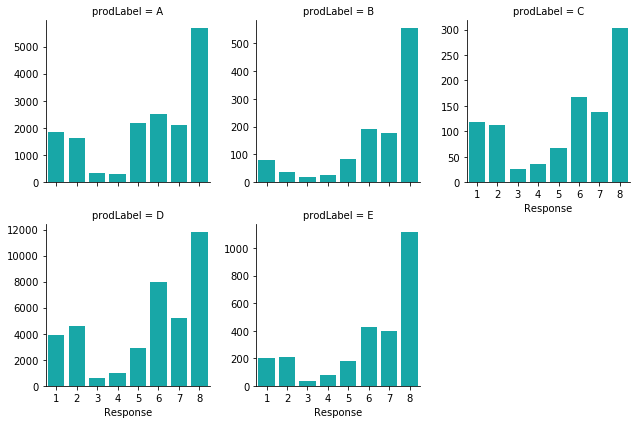

In [13]:
grid = sns.FacetGrid(df, col="prodLabel", col_wrap=3, sharey=False, 
                     sharex = True, col_order=['A', 'B', 'C', 'D', 'E'])
plots = grid.map(sns.countplot, 'Response', color = 'c')

It seems that this technique does make the distibutions relatively similar especialy when looking at the product Label. This indicates that the product label and number should enter the model seperately.

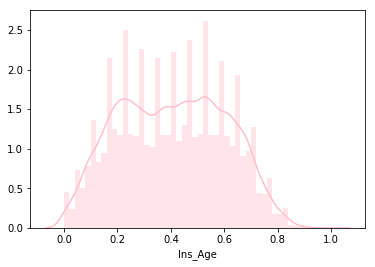

In [14]:
#distribution of age
sns.distplot(df['Ins_Age'], color='pink')

The distribution of age is has some strange spikes, perhaps indicating that the products were targeted at customers once they reach a certain age. Now we look to see age by response

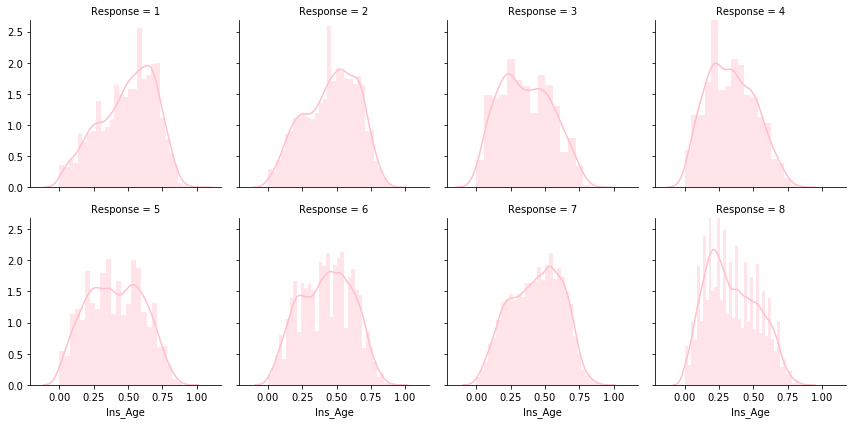

In [15]:
ageFacet = sns.FacetGrid(df, col="Response", col_wrap=4)
ageFacet.map(sns.distplot, 'Ins_Age', color='pink')

In [16]:
#mean value of age for each value of response
df.groupby('Response').agg('mean')["Ins_Age"]

Response
1    0.492908
2    0.460992
3    0.359476
4    0.337033
5    0.404595
6    0.426265
7    0.434459
8    0.342974
Name: Ins_Age, dtype: float64

We would normally expect distribution of age to vary by risk class, but in this case, the data do not appear to be moving in an intuitive way. 

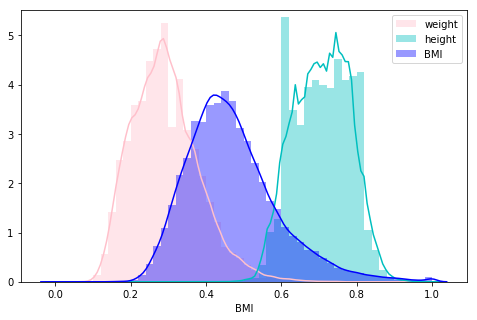

In [17]:
sns.distplot(df['Wt'], color='pink', label = 'weight')
sns.distplot(df['Ht'], color='c', label = 'height')
sns.distplot(df['BMI'], color='b', label = 'BMI')
plt.legend()
plt.gcf().set_size_inches(8, 5)

In [18]:
#A look at employment info
df.filter(regex='Emplo').head()

,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6
0,0.028,12,1,0.0,3,NaN
1,0.000,1,3,0.0,2,0.0018
2,0.030,9,1,0.0,2,0.0300
3,0.042,9,1,0.0,3,0.2000
4,0.027,9,1,0.0,2,0.0500


In [19]:
df['Employment_Info_1'].value_counts().iloc[0:5]

0.00    3688
0.05    3513
0.10    3006
0.06    2720
0.04    2395
Name: Employment_Info_1, dtype: int64

In [20]:
df['Employment_Info_2'].value_counts().iloc[0:10]

9     34573
1      8934
12     7714
14     4819
3      1724
15      480
11      456
32      199
10      175
36       63
Name: Employment_Info_2, dtype: int64

In [21]:
df['Employment_Info_3'].value_counts(dropna=False)

1    50447
3     8934
Name: Employment_Info_3, dtype: int64

In [22]:
df['Employment_Info_4'].value_counts(dropna=False).iloc[0:10]

 0.000    44659
NaN        6779
 0.010      418
 0.020      345
 0.050      338
 0.030      320
 0.005      308
 0.001      277
 0.025      228
 0.015      219
Name: Employment_Info_4, dtype: int64

In [23]:
df['Employment_Info_5'].value_counts(dropna=False)

2    50892
3     8489
Name: Employment_Info_5, dtype: int64

In [24]:
df['Employment_Info_6'].value_counts(dropna=False).iloc[0:10]

NaN      10854
 1.00     7654
 0.00     4042
 0.50     3828
 0.10     3056
 0.20     2702
 0.25     2409
 0.30     2223
 0.05     1943
 0.15     1639
Name: Employment_Info_6, dtype: int64

Its not terribly clear what the employment features indicate. However, there are two essentially dichotomos variables, that I will include as factors. There is no engineering to be done here. 

In [25]:
#A look at insured
df.filter(regex='Insured').head()

,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7
0,1,2,6,3,1,2,1
1,1,2,6,3,1,2,1
2,1,2,8,3,1,1,1
3,2,2,8,3,1,2,1
4,1,2,6,3,1,2,1


In [26]:
ins = ['InsuredInfo_1', 'InsuredInfo_2', 'InsuredInfo_3', 'InsuredInfo_4',
       'InsuredInfo_5', 'InsuredInfo_6', 'InsuredInfo_7']

In [27]:
for col in ins:
    print(col)
    print(df[col].value_counts())
    print()

InsuredInfo_1
1    47223
2    11886
3      272
Name: InsuredInfo_1, dtype: int64

InsuredInfo_2
2    58940
3      441
Name: InsuredInfo_2, dtype: int64

InsuredInfo_3
8     18736
3     16522
6     12820
11     4141
2      3828
4      1058
1       829
10      761
7       398
5       273
9        15
Name: InsuredInfo_3, dtype: int64

InsuredInfo_4
3    52473
2     6908
Name: InsuredInfo_4, dtype: int64

InsuredInfo_5
1    58574
3      807
Name: InsuredInfo_5, dtype: int64

InsuredInfo_6
1    35083
2    24298
Name: InsuredInfo_6, dtype: int64

InsuredInfo_7
1    58237
3     1144
Name: InsuredInfo_7, dtype: int64



Again, its hard to know what these data are. They can all be included as factors. No engineering possible

In [28]:
#A look at famly history
df.filter(regex='Family').head()

,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5
0,2,NaN,0.598039,NaN,0.526786
1,2,0.188406,NaN,0.084507,NaN
2,3,0.304348,NaN,0.225352,NaN
3,3,0.420290,NaN,0.352113,NaN
4,2,0.463768,NaN,0.408451,NaN


In [29]:
for col in df.filter(regex='Family').columns:
    print(col)
    print(df[col].value_counts().iloc[:10])
    print()

Family_Hist_1
3    41287
2    17556
1      538
Name: Family_Hist_1, dtype: int64

Family_Hist_2
0.434783    1331
0.420290    1199
0.463768    1188
0.405797    1157
0.391304    1118
0.362319    1073
0.507246    1016
0.449275     984
0.536232     981
0.478261     974
Name: Family_Hist_2, dtype: int64

Family_Hist_3
0.519608    1015
0.578431     853
0.549020     808
0.558824     741
0.617647     732
0.450980     715
0.539216     707
0.598039     703
0.637255     682
0.500000     681
Name: Family_Hist_3, dtype: int64

Family_Hist_4
0.408451    1621
0.366197    1381
0.338028    1379
0.394366    1348
0.380282    1300
0.323944    1273
0.436620    1249
0.309859    1211
0.507042    1200
0.450704    1171
Name: Family_Hist_4, dtype: int64

Family_Hist_5
0.535714    615
0.482143    602
0.589286    592
0.580357    582
0.571429    580
0.607143    532
0.544643    518
0.598214    513
0.508929    500
0.553571    498
Name: Family_Hist_5, dtype: int64



Similar story as above

In [30]:
#A look at medical history
df.filter(regex='Medical_History').head()

,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,...,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41
0,4.0,112,2,1,1,3,2,2,1,NaN,...,NaN,1,3,1,2,2,1,3,3,3
1,5.0,412,2,1,1,3,2,2,1,NaN,...,NaN,3,1,1,2,2,1,3,3,1
2,10.0,3,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,3,2,1,3,3,1
3,0.0,350,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,2,2,1,3,3,1
4,NaN,162,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,3,2,1,3,3,1


One thing we might try is to see if there are any dichotomous values that can be summed across columns. 

In [31]:
dic = []
for col in df.filter(regex='Medical_History').columns:
    if len(df[col].value_counts()) == 2:
        dic.append(col)
col

'Medical_History_41'

In [32]:
#A look at medical history
df.filter(regex='Medical_History').head()

,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_10,...,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41
0,4.0,112,2,1,1,3,2,2,1,NaN,...,NaN,1,3,1,2,2,1,3,3,3
1,5.0,412,2,1,1,3,2,2,1,NaN,...,NaN,3,1,1,2,2,1,3,3,1
2,10.0,3,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,3,2,1,3,3,1
3,0.0,350,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,2,2,1,3,3,1
4,NaN,162,2,2,1,3,2,2,2,NaN,...,NaN,3,3,1,3,2,1,3,3,1


In [33]:
#A look at medical keywords
df.filter(regex='Medical_Key').head()

,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


As per the data dictionary these are all dichotomous variables. One feature that could be engineered is to sum the keywords to give an overall picture of health. It will certainly help in visualizing this mass of information. We would expect higher values of medical keywords in higher risk classes. This assumes that these variables indiate an impairment and not a positive health aspect 

In [34]:
df['health_sum'] = df.filter(regex='Medical_Key').sum(axis=1)

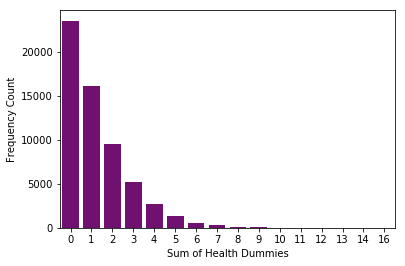

In [35]:
sns.countplot(df['health_sum'], color='purple', label = 'weight')
plt.xlabel("Sum of Health Dummies")
plt.ylabel("Frequency Count")

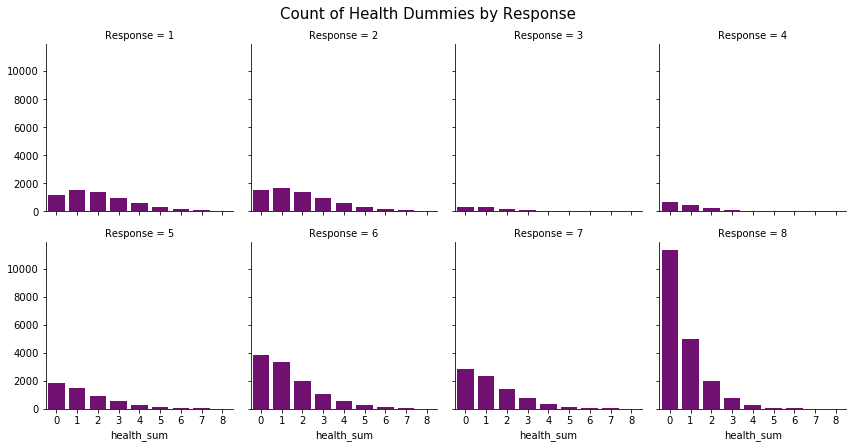

In [40]:
ageFacet = sns.FacetGrid(df, col="Response", col_wrap=4)
ageFacet.map(sns.countplot, 'health_sum', color='purple')
plt.suptitle("Count of Health Dummies by Response", size = 15, y=1.03)

If we think that a greater helth score means an unhealthier person, then responses 6, 7 and 8 seem to have a greater proportion of healthier people (more zeros). Response 1 and 2 have a greater proportion of slightly less healthier people. Its possible that this health indicator will be predictive. 

---

## Missing Values

First I display the number of missing observations for observations that have any missing values.

In [37]:
dataGroups = ['Product', 'Employment', 'Insured', 'Insurance', 'Family', 'Medical_History', 'Medical_Key']
for group in dataGroups:
    nulls = pd.DataFrame(df.filter(regex=group).isnull().sum(), columns=['numNulls'])
    print(nulls[nulls['numNulls']!=0])

Empty DataFrame
Columns: [numNulls]
Index: []
                   numNulls
Employment_Info_1        19
Employment_Info_4      6779
Employment_Info_6     10854
Empty DataFrame
Columns: [numNulls]
Index: []
                     numNulls
Insurance_History_5     25396
               numNulls
Family_Hist_2     28656
Family_Hist_3     34241
Family_Hist_4     19184
Family_Hist_5     41811
                    numNulls
Medical_History_1       8889
Medical_History_10     58824
Medical_History_15     44596
Medical_History_24     55580
Medical_History_32     58274
Empty DataFrame
Columns: [numNulls]
Index: []


For the vast majority of columns there are no missing data. There are missing values for some employment, family and medical history. However, null values do not need to be excluded for gradient boosting machines. No action needs to be taken for these missing values. 